In [1]:
import pandas
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.special
from matplotlib import pyplot as plt
%matplotlib inline


In [215]:
myfile = pandas.ExcelFile('/home/ms142/museami/Hook\'d Track Engagement Performance.xlsx')
df = pandas.ExcelFile.parse(myfile,sheetname='Daily Filtered').dropna()

In [216]:
myfile = pandas.ExcelFile('/home/ms142/museami/Copy of Niche Influencer Activation Data.xlsx')
niche = pandas.ExcelFile.parse(myfile,index_col=0).dropna()
niche.rename(columns=lambda x : x.replace(' ','_'),inplace=True)

In [217]:
myfile = pandas.ExcelFile('/home/ms142/museami/Google Analytics Data Extraction Mk II.xlsx')
engagement = pandas.ExcelFile.parse(myfile,sheetname='Engagement Daily',header=1,index_col=0).dropna()
engagement.index = pandas.DatetimeIndex(engagement.index)
engagement.rename(columns={'1 day':'Regs','1 day.1':'Sales_Count','1 day.2':'Hooks_Dropped'},inplace=True)

In [218]:
myfile = pandas.ExcelFile('/home/ms142/museami/Hook\'d in-app track timing.xlsx')
inout= pandas.ExcelFile.parse(myfile,sheetname='Track inout')
inout = inout[pandas.notnull(inout['Track ID'])]

In [219]:
niche['Number_of_Followers']=niche['Number_of_Followers'].str.replace('M','').astype(float)

In [230]:
rollingRegs = pandas.rolling_mean(engagement['Regs'],7)
rollingSales = pandas.rolling_mean(engagement['Sales_Count'],7)
rollingHooks = pandas.rolling_mean(engagement['Hooks_Dropped'],7)
avgRegs = engagement['Regs'].loc[niche.index[0]:].mean()
avgSales = engagement['Sales_Count'].loc[niche.index[0]:].mean()
avgHooks = engagement['Hooks_Dropped'].loc[niche.index[0]:].mean()

In [232]:
engagement['rollingHooks'] = rollingHooks.shift(1)
engagement['normHooks'] = (engagement['Hooks_Dropped'].shift(0))/engagement['rollingHooks']
engagement['normHooks_lag1'] = engagement['normHooks'].shift(1)
infeffect = niche.join(engagement,how='right')
infeffect['Loops_to_date'].fillna(0,inplace=True)
res = smf.ols(data=infeffect,formula='normHooks ~ Loops_to_date + normHooks_lag1').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              normHooks   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     57.83
Date:                Fri, 13 Mar 2015   Prob (F-statistic):           4.35e-21
Time:                        12:25:26   Log-Likelihood:                -32.057
No. Observations:                 234   AIC:                             70.11
Df Residuals:                     231   BIC:                             80.48
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          0.4473      0.057      7.803      0.000         0.334     0.560
Loops_to_date   2.888e-08   9.81e-09      2.944      0.004      9.55e-09  4.82e-08
normHooks_lag1     0.5470      0.054     10.171      0.000         0.441     0.653
==============================================================================
Omnibus:                      102.493   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              441.821
Skew:                           1.759   Prob(JB):                     1.15e-96
Kurtosis:                       8.739   Cond. No.                     8.07e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [241]:
loopOnRegs=[]
loopOnSales=[]
loopOnHooks=[]
dayLag = range(0,31)

for i in dayLag:
    engagement['rollingRegs'] = rollingRegs.shift(-i+1)
    engagement['rollingSales'] = rollingSales.shift(-i+1)
    engagement['rollingHooks'] = rollingHooks.shift(-i+1)
    engagement['normRegs'] = (engagement['Regs'].shift(-i))/engagement['rollingRegs']
    engagement['normSales'] = (engagement['Sales_Count'].shift(-i))/engagement['rollingSales']
    engagement['normHooks'] = (engagement['Hooks_Dropped'].shift(-i))/engagement['rollingHooks']
    engagement['normRegs_lag1'] = engagement['normRegs'].shift(1)
    engagement['normSales_lag1'] = engagement['normSales'].shift(1)
    engagement['normHooks_lag1'] = engagement['normHooks'].shift(1)
    infeffect = niche.join(engagement,how='right')
    infeffect['Loops_to_date'].fillna(0,inplace=True)
    res = smf.ols(data=infeffect,formula='normRegs ~ Loops_to_date + normRegs_lag1').fit()
    loopOnRegs.append(res.params.Loops_to_date)
    res = smf.ols(data=infeffect,formula='normSales ~ Loops_to_date + normSales_lag1').fit()
    loopOnSales.append(res.params.Loops_to_date)
    res = smf.ols(data=infeffect,formula='normHooks ~ Loops_to_date + normHooks_lag1').fit()
    loopOnHooks.append(res.params.Loops_to_date)
    

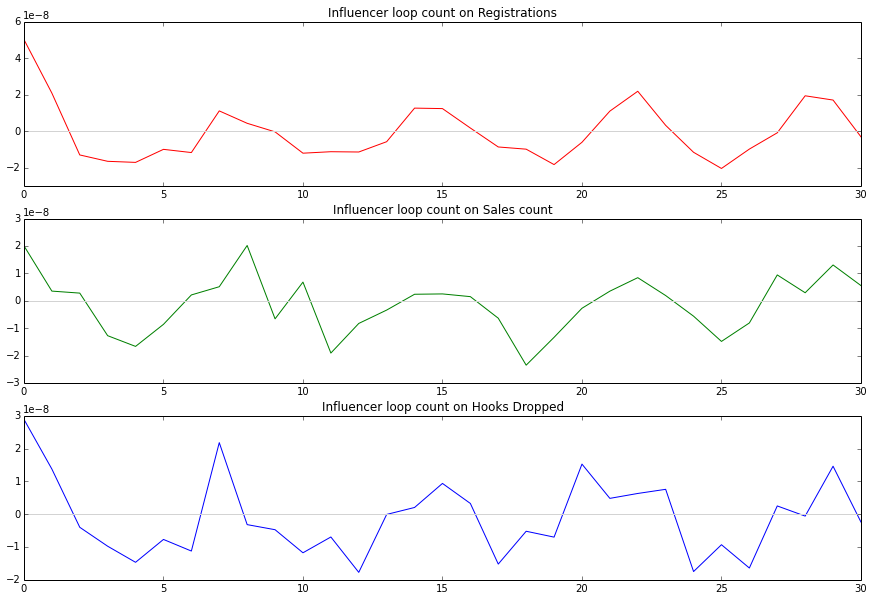

In [242]:
fig = plt.figure(figsize=[15,10])
ax=fig.add_subplot(3,1,1)
ax.set_title('Influencer loop count on Registrations')
plt.plot(dayLag,loopOnRegs,'r-',dayLag,np.zeros(len(dayLag)),'lightgrey')
ax=fig.add_subplot(3,1,2)
ax.set_title('Influencer loop count on Sales count')
plt.plot(dayLag,loopOnSales,'g-',dayLag,np.zeros(len(dayLag)),'lightgrey')
ax=fig.add_subplot(3,1,3)
ax.set_title('Influencer loop count on Hooks Dropped')
plt.plot(dayLag,loopOnHooks,'b-',dayLag,np.zeros(len(dayLag)),'lightgrey')